### Trying to understand condition-specific regulator clusters
#### (1) Is it because regulators or downstream genes are only expressed in one/some conditions?
#### (2) Is this mainly a quantitative effect: quantitative change in expression alters power and/or regulatory connections become stronger

In [2]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import linkage

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [3]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data'

In [4]:
adata_de = sc.read_h5ad(datadir + f'/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad')
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
adata_de.X = np.nan_to_num(adata_de.layers['zscore'], 0)

In [5]:
adata_final = sc.read_h5ad(datadir + '/analysis_largefiles/nde50ntotal100_varfiltered_clustering.h5ad')

In [6]:
de_summary_stats = pd.read_csv(datadir + '/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
de_summary_stats.baseMean = de_summary_stats.baseMean.fillna(0)
de_summary_stats = de_summary_stats.set_index('obs_names')

In [7]:
downstream_gene_df = pd.read_csv(datadir + '/analysis_largefiles/nde50ntotal100_varfiltered_clustering_downstream_genes.csv', index_col=0)

In [8]:
downstream_gene_df

,hdbscan_cluster,downstream_gene,downstream_gene_ids,num_of_upstream,sign_coherence,zscore_rank_negative_regulation,zscore_rank_positive_regulation
0,36,DPM1,ENSG00000000419,10,-1.000000,398,9600
1,36,SCYL3,ENSG00000000457,13,0.846154,7998,2000
2,36,C1orf112,ENSG00000000460,5,-0.600000,2759,7239
3,36,CFH,ENSG00000000971,2,1.000000,5837,4161
4,36,FUCA2,ENSG00000001036,6,1.000000,5860,4138
...,...,...,...,...,...,...,...
1646,78,ZNF8,ENSG00000278129,2,-1.000000,365,1287
1647,78,GGNBP2,ENSG00000278311,1,-1.000000,500,1151
1648,78,C2orf81,ENSG00000284308,1,1.000000,977,675
1649,78,HOMEZ,ENSG00000290292,1,1.000000,855,797


In [9]:
def corr_compute(adata, gene_list):
    mask = adata.obs.target_contrast_gene_name.isin(genelist)
    rest = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name').index].X.copy()
    stim8hr = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name').index].X.copy()
    stim48hr = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name').index].X.copy()
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name').index].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name').index].obs.culture_condition.values.tolist()
    ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
    data = np.concatenate([rest, stim8hr, stim48hr])
            
    df = pd.DataFrame(data=data,
                      index=ind,
                      columns=adata.var_names)
    df_corr = df.T.corr()
    return df_corr

In [10]:
downstream_gene_df[downstream_gene_df['hdbscan_cluster']==40]

,hdbscan_cluster,downstream_gene,downstream_gene_ids,num_of_upstream,sign_coherence,zscore_rank_negative_regulation,zscore_rank_positive_regulation
0,40,MAD1L1,ENSG00000002822,1,1.0,413,514
1,40,ARHGAP33,ENSG00000004777,2,1.0,474,453
2,40,TSPOAP1,ENSG00000005379,1,-1.0,210,717
3,40,WDR54,ENSG00000005448,1,-1.0,224,703
4,40,RHBDD2,ENSG00000005486,1,1.0,734,193
...,...,...,...,...,...,...,...
921,40,TAF15,ENSG00000270647,1,1.0,622,305
922,40,GTF2H5,ENSG00000272047,1,-1.0,167,760
923,40,ZNF595,ENSG00000272602,1,1.0,436,490
924,40,TUBGCP5,ENSG00000275835,1,1.0,542,385


In [11]:
adata_de

AnnData object with n_obs × n_vars = 33983 × 13959
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [12]:
adata_final[adata_final.obs['hdbscan']==3].obs['culture_condition'].value_counts().index[0]

'Stim8hr'

In [13]:
de_summary_stats

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,target_name_corrected
obs_names,,,,,,,,,,,,,,,
ENSG00000012963_Stim8hr,ENSG00000012963,UBR7,Stim8hr,491.0,0,2,2,-12.952742,True,43.169196,True,2-10 DE genes,on-target KD,ENSG00000012963,UBR7
ENSG00000017260_Stim8hr,ENSG00000017260,ATP2C1,Stim8hr,469.0,0,1,1,-16.307246,True,102.399025,False,1 DE gene,on-target KD,ENSG00000017260,ATP2C1
ENSG00000067606_Stim8hr,ENSG00000067606,PRKCZ,Stim8hr,427.0,1,1,2,-1.658755,False,0.965897,False,2-10 DE genes,no on-target KD,ENSG00000067606,PRKCZ
ENSG00000092929_Stim8hr,ENSG00000092929,UNC13D,Stim8hr,830.0,0,2,2,-19.259466,True,60.904483,False,2-10 DE genes,on-target KD,ENSG00000092929,UNC13D
ENSG00000100504_Stim8hr,ENSG00000100504,PYGL,Stim8hr,414.0,1,0,1,0.000000,False,0.000000,False,1 DE gene,no on-target KD,ENSG00000100504,PYGL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198342_Rest,ENSG00000198342,ZNF442,Rest,324.0,0,0,0,0.000000,False,0.000000,False,no effect,no on-target KD,ENSG00000198342,ZNF442
ENSG00000205572_Rest,ENSG00000205572,SERF1B,Rest,44.0,7,24,31,0.000000,False,0.000000,False,>10 DE genes,no on-target KD,ENSG00000205572,SERF1B
ENSG00000221890_Rest,ENSG00000221890,NPTXR,Rest,293.0,0,3,3,-1.027171,False,0.798092,False,2-10 DE genes,no on-target KD,ENSG00000221890,NPTXR


In [20]:
fontsize=20
for cl in adata_final.obs.hdbscan.unique():
    # For each cluster, choose the top 100 down-regulated genes and 100 up-regulated genes for analysis
    mask = (downstream_gene_df['hdbscan_cluster']==cl) & ((downstream_gene_df['zscore_rank_negative_regulation']<=100) | (downstream_gene_df['zscore_rank_positive_regulation']<=100))
    # Only include downstream genes that are in the summary statistics to get good estimate of baseMean
    downstream_gene = downstream_gene_df[mask]['downstream_gene_ids'].tolist()
    downstream_gene = set(downstream_gene) \
    & set(de_summary_stats[de_summary_stats['condition']=='Rest']['target_contrast_corrected']) \
    & set(de_summary_stats[de_summary_stats['condition']=='Stim8hr']['target_contrast_corrected']) \
    & set(de_summary_stats[de_summary_stats['condition']=='Stim48hr']['target_contrast_corrected'])
    downstream_gene = list(downstream_gene)
    
    # For each cluster, get regulator member list
    regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_corrected'].tolist()
    
    # (Only for this analysis), only include regulators that have DE analysis included in all three conditions and are measured in gene expression matrix
    regulator = [item for item in regulator if np.sum(adata_de.obs['target_contrast_corrected']==item)==3]
    regulator = [item for item in regulator if item in adata_de.var_names]
    
    # First curate the regulatory interaction of the main condition
    main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
    regulator_main_condition = [item+'_'+main_condition for item in regulator]
    regulator_downstream_main_condition = pd.DataFrame(data=adata_de[regulator_main_condition, downstream_gene].layers['zscore'],
                                                       index=regulator_main_condition,
                                                       columns=downstream_gene)
    
    # Get reordered downstream genes based on DE effect of main condition
    clustermap = sns.clustermap(regulator_downstream_main_condition, 
                                method='average', 
                                metric='euclidean')
    xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    yticklabel_indices = clustermap.dendrogram_row.reordered_ind
    plt.close(clustermap.fig)
    downstream_gene = np.array(downstream_gene)[xticklabel_indices]
    #regulator = np.array(regulator)[yticklabel_indices]

    # Curate expression of regulator members for reordering regulators
    regulator_rest_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Rest' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Rest'])
    regulator_stim8hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim8hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim8hr'])
    regulator_stim48hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim48hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim48hr'])
    regulator_exp = pd.concat([regulator_rest_exp, regulator_stim8hr_exp, regulator_stim48hr_exp], axis=1)
    
    clustermap = sns.clustermap(np.log1p(regulator_exp.T), row_cluster=False)
    plt.close(clustermap.fig)
    xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    regulator = np.array(regulator)[xticklabel_indices]
    
    # Curate their regulatory interactions
    regulator_rest = [item+'_Rest' for item in regulator]
    regulator_stim8hr = [item+'_Stim8hr' for item in regulator]
    regulator_stim48hr = [item+'_Stim48hr' for item in regulator]
    regulator_downstream_rest = pd.DataFrame(data=adata_de[regulator_rest, downstream_gene].layers['zscore'],
                                             index=regulator_rest,
                                             columns=downstream_gene)
    regulator_downstream_stim8hr = pd.DataFrame(data=adata_de[regulator_stim8hr, downstream_gene].layers['zscore'],
                                                index=regulator_stim8hr,
                                                columns=downstream_gene)
    regulator_downstream_stim48hr = pd.DataFrame(data=adata_de[regulator_stim48hr, downstream_gene].layers['zscore'],
                                                 index=regulator_stim48hr,
                                                 columns=downstream_gene)
    
    # Curate expression of downstream genes (now reordered)
    downstream_rest_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Rest' for item in adata_de.var.loc[downstream_gene, 'gene_ids']], 'baseMean'].values,
                                   index=downstream_gene,
                                   columns=['baseMean_Rest'])
    downstream_stim8hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim8hr' for item in adata_de.var.loc[downstream_gene, 'gene_ids']], 'baseMean'].values,
                                   index=downstream_gene,
                                   columns=['baseMean_Stim8hr'])
    downstream_stim48hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim48hr' for item in adata_de.var.loc[downstream_gene, 'gene_ids']], 'baseMean'].values,
                                   index=downstream_gene,
                                   columns=['baseMean_Stim48hr'])
    downstream_exp = pd.concat([downstream_rest_exp, downstream_stim8hr_exp, downstream_stim48hr_exp], axis=1)
    
    # Curate expression of regulator members
    regulator_rest_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Rest' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Rest'])
    regulator_stim8hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim8hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim8hr'])
    regulator_stim48hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim48hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim48hr'])
    regulator_exp = pd.concat([regulator_rest_exp, regulator_stim8hr_exp, regulator_stim48hr_exp], axis=1)
    
    # Make plot
    fig, ax = plt.subplots(2,4,figsize=(20,8))
    
    # Regulator expression
    # clustermap = sns.clustermap(np.log1p(regulator_exp.T), row_cluster=False)
    # plt.close(clustermap.fig)
    # xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    # sns.heatmap(np.log1p(regulator_exp.iloc[xticklabel_indices].T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[0,0])
    sns.heatmap(np.log1p(regulator_exp), yticklabels=False, xticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[0,0])
    ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), fontsize=fontsize)
    ax[0,0].set_ylabel('Regulators', fontsize=fontsize)
    ax[0,0].set_title('Regulator expression', fontsize=fontsize)
    
    # Downstream gene expression
    # clustermap = sns.clustermap(np.log1p(downstream_exp.T), row_cluster=False)
    # plt.close(clustermap.fig)
    # xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    #sns.heatmap(np.log1p(downstream_exp.iloc[xticklabel_indices].T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[1,0])
    sns.heatmap(np.log1p(downstream_exp.T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[1,0])
    ax[1,0].set_xlabel('Top 200 downstream genes', fontsize=fontsize)
    ax[1,0].set_yticklabels(ax[1,0].get_yticklabels(), fontsize=fontsize, rotation=0, ha='right')
    ax[1,0].set_title('Downstream gene expression', fontsize=fontsize)
    
    # Regulator-downstream plot
    vscale = np.mean([np.mean(np.abs(regulator_downstream_rest)), np.mean(np.abs(regulator_downstream_stim8hr)), np.mean(np.abs(regulator_downstream_stim48hr))])
    sns.heatmap(regulator_downstream_rest, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[0,1])
    ax[0,1].set_title('Rest DE zscore', fontsize=fontsize)
    ax[0,1].set_xlabel('Top 200 downstream genes', fontsize=fontsize)
    ax[0,1].set_ylabel('Regulators', fontsize=fontsize)
    sns.heatmap(regulator_downstream_stim8hr, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[0,2])
    ax[0,2].set_title('Stim8hr DE zscore', fontsize=fontsize)
    ax[0,2].set_xlabel('Top 200 downstream genes', fontsize=fontsize)
    ax[0,2].set_ylabel('Regulators', fontsize=fontsize)
    sns.heatmap(regulator_downstream_stim48hr, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[0,3])
    ax[0,3].set_title('Stim48hr DE zscore', fontsize=fontsize)
    ax[0,3].set_xlabel('Top 200 downstream genes', fontsize=fontsize)
    ax[0,3].set_ylabel('Regulators', fontsize=fontsize)
    
    # Normalized regulator-downstream plot
    sns.heatmap(regulator_downstream_rest/np.mean(np.abs(regulator_downstream_rest)), vmin=-3, vmax=3, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[1,1])
    ax[1,1].set_title('Rest normalized DE zscore', fontsize=fontsize)
    ax[1,1].set_xlabel('Top 200 downstream genes', fontsize=fontsize)
    ax[1,1].set_ylabel('Regulators', fontsize=fontsize)
    sns.heatmap(regulator_downstream_stim8hr/np.mean(np.abs(regulator_downstream_stim8hr)), vmin=-3, vmax=3, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[1,2])
    ax[1,2].set_title('Stim8hr normalized DE zscore', fontsize=20)
    ax[1,2].set_xlabel('Top 200 downstream genes', fontsize=12)
    ax[1,2].set_ylabel('Regulators', fontsize=12)
    sns.heatmap(regulator_downstream_stim48hr/np.mean(np.abs(regulator_downstream_stim48hr)), vmin=-3, vmax=3, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[1,3])
    ax[1,3].set_title('Stim48hr normalized DE zscore', fontsize=fontsize)
    ax[1,3].set_xlabel('Top 200 downstream genes', fontsize=fontsize)
    ax[1,3].set_ylabel('Regulators', fontsize=fontsize)
    plt.suptitle('cluster '+str(cl), fontsize=36)
    plt.tight_layout()
    plt.savefig('./results/cluster_by_condition/cluster'+str(cl)+'.png')
    plt.close('all')

<Axes: >

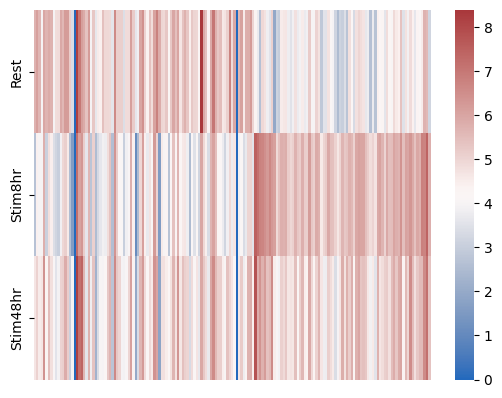

In [309]:
sns.heatmap(np.log1p(downstream_exp.T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

<Axes: >

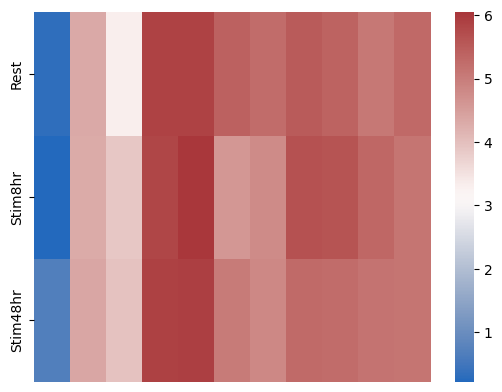

In [298]:
clustermap = sns.clustermap(np.log1p(regulator_exp.T), row_cluster=False)
plt.close(clustermap.fig)
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
sns.heatmap(np.log1p(regulator_exp.iloc[xticklabel_indices].T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

<Axes: >

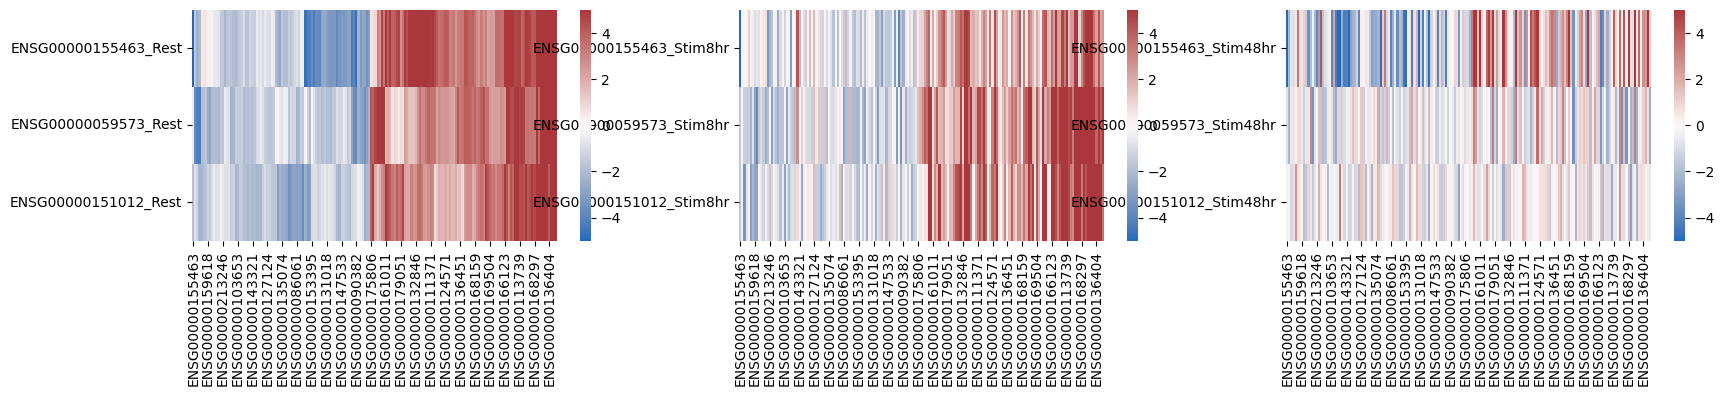

In [281]:
thres = 5
fig, ax = plt.subplots(1,3,figsize=(20,3))
sns.heatmap(regulator_downstream_rest, vmin=-thres, vmax=thres, cmap='vlag', ax=ax[0])
sns.heatmap(regulator_downstream_stim8hr, vmin=-thres, vmax=thres, cmap='vlag', ax=ax[1])
sns.heatmap(regulator_downstream_stim48hr, vmin=-thres, vmax=thres, cmap='vlag', ax=ax[2])

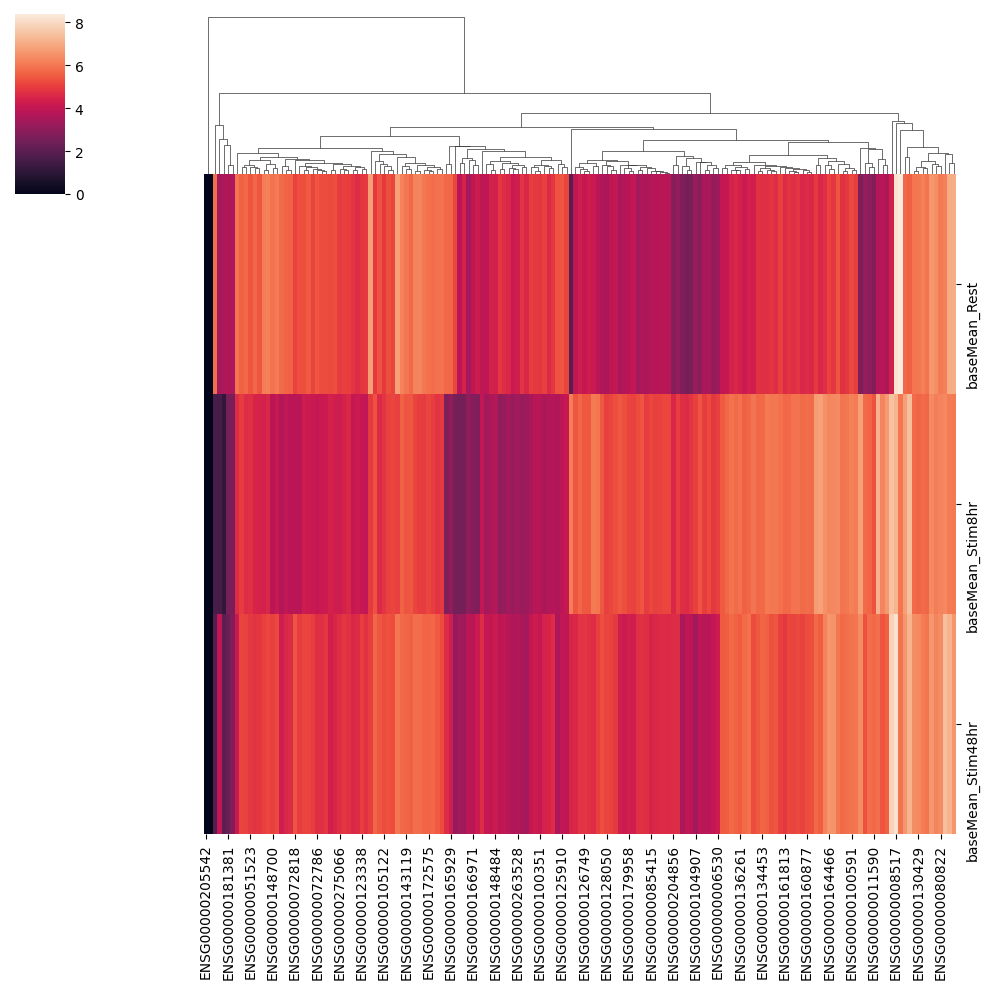

In [297]:
sns.clustermap(np.log1p(downstream_exp.T), row_cluster=False)

In [328]:
adata_de

AnnData object with n_obs × n_vars = 33983 × 13959
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [330]:
for cl in adata_final.obs.hdbscan.unique():
    # For each cluster, choose the top 100 down-regulated genes and 100 up-regulated genes for analysis
    mask = (downstream_gene_df['hdbscan_cluster']==cl) & ((downstream_gene_df['zscore_rank_negative_regulation']<=100) | (downstream_gene_df['zscore_rank_positive_regulation']<=100))
    # Only include downstream genes that are in the summary statistics to get good estimate of baseMean
    downstream_gene = downstream_gene_df[mask]['downstream_gene_ids'].tolist()
    downstream_gene = set(downstream_gene) \
    & set(de_summary_stats[de_summary_stats['condition']=='Rest']['target_contrast_corrected']) \
    & set(de_summary_stats[de_summary_stats['condition']=='Stim8hr']['target_contrast_corrected']) \
    & set(de_summary_stats[de_summary_stats['condition']=='Stim48hr']['target_contrast_corrected'])
    downstream_gene = list(downstream_gene)
    
    # For each cluster, get regulator member list
    regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_corrected'].tolist()
    
    # (Only for this analysis), only include regulators that have DE analysis included in all three conditions and are measured in gene expression matrix
    regulator = [item for item in regulator if np.sum(adata_de.obs['target_contrast_corrected']==item)==3]
    regulator = [item for item in regulator if item in adata_de.var_names]
    
    # First curate the regulatory interaction of the main condition
    main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
    regulator_main_condition = [item+'_'+main_condition for item in regulator]
    regulator_downstream_main_condition = pd.DataFrame(data=adata_de[regulator_main_condition, downstream_gene].layers['log_fc'],
                                                       index=regulator_main_condition,
                                                       columns=downstream_gene)
    
    # Get reordered downstream genes based on DE effect of main condition
    clustermap = sns.clustermap(regulator_downstream_main_condition, 
                                method='average', 
                                metric='euclidean')
    xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    yticklabel_indices = clustermap.dendrogram_row.reordered_ind
    plt.close(clustermap.fig)
    downstream_gene = np.array(downstream_gene)[xticklabel_indices]
    #regulator = np.array(regulator)[yticklabel_indices]

    # Curate expression of regulator members for reordering regulators
    regulator_rest_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Rest' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Rest'])
    regulator_stim8hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim8hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim8hr'])
    regulator_stim48hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim48hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim48hr'])
    regulator_exp = pd.concat([regulator_rest_exp, regulator_stim8hr_exp, regulator_stim48hr_exp], axis=1)
    
    clustermap = sns.clustermap(np.log1p(regulator_exp.T), row_cluster=False)
    plt.close(clustermap.fig)
    xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    regulator = np.array(regulator)[xticklabel_indices]
    
    # Curate their regulatory interactions
    regulator_rest = [item+'_Rest' for item in regulator]
    regulator_stim8hr = [item+'_Stim8hr' for item in regulator]
    regulator_stim48hr = [item+'_Stim48hr' for item in regulator]
    regulator_downstream_rest = pd.DataFrame(data=adata_de[regulator_rest, downstream_gene].layers['log_fc'],
                                             index=regulator_rest,
                                             columns=downstream_gene)
    regulator_downstream_stim8hr = pd.DataFrame(data=adata_de[regulator_stim8hr, downstream_gene].layers['log_fc'],
                                                index=regulator_stim8hr,
                                                columns=downstream_gene)
    regulator_downstream_stim48hr = pd.DataFrame(data=adata_de[regulator_stim48hr, downstream_gene].layers['log_fc'],
                                                 index=regulator_stim48hr,
                                                 columns=downstream_gene)
    
    # Curate expression of downstream genes (now reordered)
    downstream_rest_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Rest' for item in adata_de.var.loc[downstream_gene, 'gene_ids']], 'baseMean'].values,
                                   index=downstream_gene,
                                   columns=['baseMean_Rest'])
    downstream_stim8hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim8hr' for item in adata_de.var.loc[downstream_gene, 'gene_ids']], 'baseMean'].values,
                                   index=downstream_gene,
                                   columns=['baseMean_Stim8hr'])
    downstream_stim48hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim48hr' for item in adata_de.var.loc[downstream_gene, 'gene_ids']], 'baseMean'].values,
                                   index=downstream_gene,
                                   columns=['baseMean_Stim48hr'])
    downstream_exp = pd.concat([downstream_rest_exp, downstream_stim8hr_exp, downstream_stim48hr_exp], axis=1)
    
    # Curate expression of regulator members
    regulator_rest_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Rest' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Rest'])
    regulator_stim8hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim8hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim8hr'])
    regulator_stim48hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim48hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim48hr'])
    regulator_exp = pd.concat([regulator_rest_exp, regulator_stim8hr_exp, regulator_stim48hr_exp], axis=1)
    
    # Make plot
    fig, ax = plt.subplots(2,4,figsize=(20,6))
    
    # Regulator expression
    # clustermap = sns.clustermap(np.log1p(regulator_exp.T), row_cluster=False)
    # plt.close(clustermap.fig)
    # xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    # sns.heatmap(np.log1p(regulator_exp.iloc[xticklabel_indices].T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[0,0])
    sns.heatmap(np.log1p(regulator_exp), yticklabels=False, xticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[0,0])
    ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), fontsize=12)
    ax[0,0].set_ylabel('Regulators', fontsize=12)
    ax[0,0].set_title('Regulator expression')
    
    # Downstream gene expression
    # clustermap = sns.clustermap(np.log1p(downstream_exp.T), row_cluster=False)
    # plt.close(clustermap.fig)
    # xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    #sns.heatmap(np.log1p(downstream_exp.iloc[xticklabel_indices].T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[1,0])
    sns.heatmap(np.log1p(downstream_exp.T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[1,0])
    ax[1,0].set_xlabel('Downstream genes', fontsize=12)
    ax[1,0].set_yticklabels(ax[1,0].get_yticklabels(), fontsize=12, rotation=0, ha='right')
    ax[1,0].set_title('Downstream gene expression')
    
    # Regulator-downstream plot
    vscale = np.mean([np.mean(np.abs(regulator_downstream_rest)), np.mean(np.abs(regulator_downstream_stim8hr)), np.mean(np.abs(regulator_downstream_stim48hr))])
    sns.heatmap(regulator_downstream_rest, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[0,1])
    ax[0,1].set_title('Rest DE lfc')
    ax[0,1].set_xlabel('Downstream genes', fontsize=12)
    ax[0,1].set_ylabel('Regulators', fontsize=12)
    sns.heatmap(regulator_downstream_stim8hr, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[0,2])
    ax[0,2].set_title('Stim8hr DE lfc')
    ax[0,2].set_xlabel('Downstream genes', fontsize=12)
    ax[0,2].set_ylabel('Regulators', fontsize=12)
    sns.heatmap(regulator_downstream_stim48hr, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[0,3])
    ax[0,3].set_title('Stim48hr DE lfc')
    ax[0,3].set_xlabel('Downstream genes', fontsize=12)
    ax[0,3].set_ylabel('Regulators', fontsize=12)
    
    # Normalized regulator-downstream plot
    sns.heatmap(regulator_downstream_rest/np.mean(np.abs(regulator_downstream_rest)), vmin=-3, vmax=3, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[1,1])
    ax[1,1].set_title('Rest normalized DE lfc')
    ax[1,1].set_xlabel('Downstream genes', fontsize=12)
    ax[1,1].set_ylabel('Regulators', fontsize=12)
    sns.heatmap(regulator_downstream_stim8hr/np.mean(np.abs(regulator_downstream_stim8hr)), vmin=-3, vmax=3, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[1,2])
    ax[1,2].set_title('Stim8hr normalized DE lfc')
    ax[1,2].set_xlabel('Downstream genes', fontsize=12)
    ax[1,2].set_ylabel('Regulators', fontsize=12)
    sns.heatmap(regulator_downstream_stim48hr/np.mean(np.abs(regulator_downstream_stim48hr)), vmin=-3, vmax=3, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[1,3])
    ax[1,3].set_title('Stim48hr normalized DE lfc')
    ax[1,3].set_xlabel('Downstream genes', fontsize=12)
    ax[1,3].set_ylabel('Regulators', fontsize=12)
    plt.suptitle('cluster '+str(cl), fontsize=24)
    plt.tight_layout()
    plt.savefig('./results/cluster_by_condition/cluster'+str(cl)+'_lfc.png')
    plt.close('all')

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` 

In [31]:
adata_de[regulator_rest, downstream_gene].layers['zscore'].shape

(11, 200)

In [23]:
adata_final.obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000104368_Stim8hr,PLAT,Stim8hr,ENSG00000104368,0,411.0,ENSG00000104368,PLAT,36
ENSG00000128607_Stim8hr,KLHDC10,Stim8hr,ENSG00000128607,0,1257.0,ENSG00000128607,KLHDC10,66
ENSG00000163600_Stim8hr,ICOS,Stim8hr,ENSG00000163600,0,658.0,ENSG00000163600,ICOS,66
ENSG00000174177_Stim8hr,CTU2,Stim8hr,ENSG00000174177,0,500.0,ENSG00000174177,CTU2,20
ENSG00000108064_Stim48hr,TFAM,Stim48hr,ENSG00000108064,1,414.0,ENSG00000108064,TFAM,71
...,...,...,...,...,...,...,...,...
ENSG00000127152_Stim48hr,BCL11B,Stim48hr,ENSG00000127152,679,203.0,ENSG00000127152,BCL11B,101
ENSG00000134323_Rest,MYCN,Rest,ENSG00000134323,680,924.0,ENSG00000134323,MYCN,21
ENSG00000137265_Rest,MUM1,Rest,ENSG00000137265,680,803.0,ENSG00000137265,IRF4,90
ENSG00000157426_Rest,AASDH,Rest,ENSG00000157426,680,651.0,ENSG00000157426,AASDH,91


In [8]:
adata_final

AnnData object with n_obs × n_vars = 1959 × 10799
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'hdbscan'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [10]:
def corr_compute(adata, gene_list):
    mask = adata.obs.target_contrast_gene_name.isin(genelist)
    rest = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name').index].X.copy()
    stim8hr = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name').index].X.copy()
    stim48hr = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name').index].X.copy()
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name').index].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name').index].obs.culture_condition.values.tolist()
    ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
    data = np.concatenate([rest, stim8hr, stim48hr])
            
    test = pd.DataFrame(data=data,
                        index=ind,
                        columns=adata.var_names)
    test2 = test.T.corr()
    return test2

In [11]:
adata_final.obs.hdbscan.unique()

[36, 66, 20, 71, 96, ..., 59, 85, 83, 67, 78]
Length: 55
Categories (55, int64): [0, 2, 3, 4, ..., 96, 97, 98, 101]

### First identify condition-specific clusters

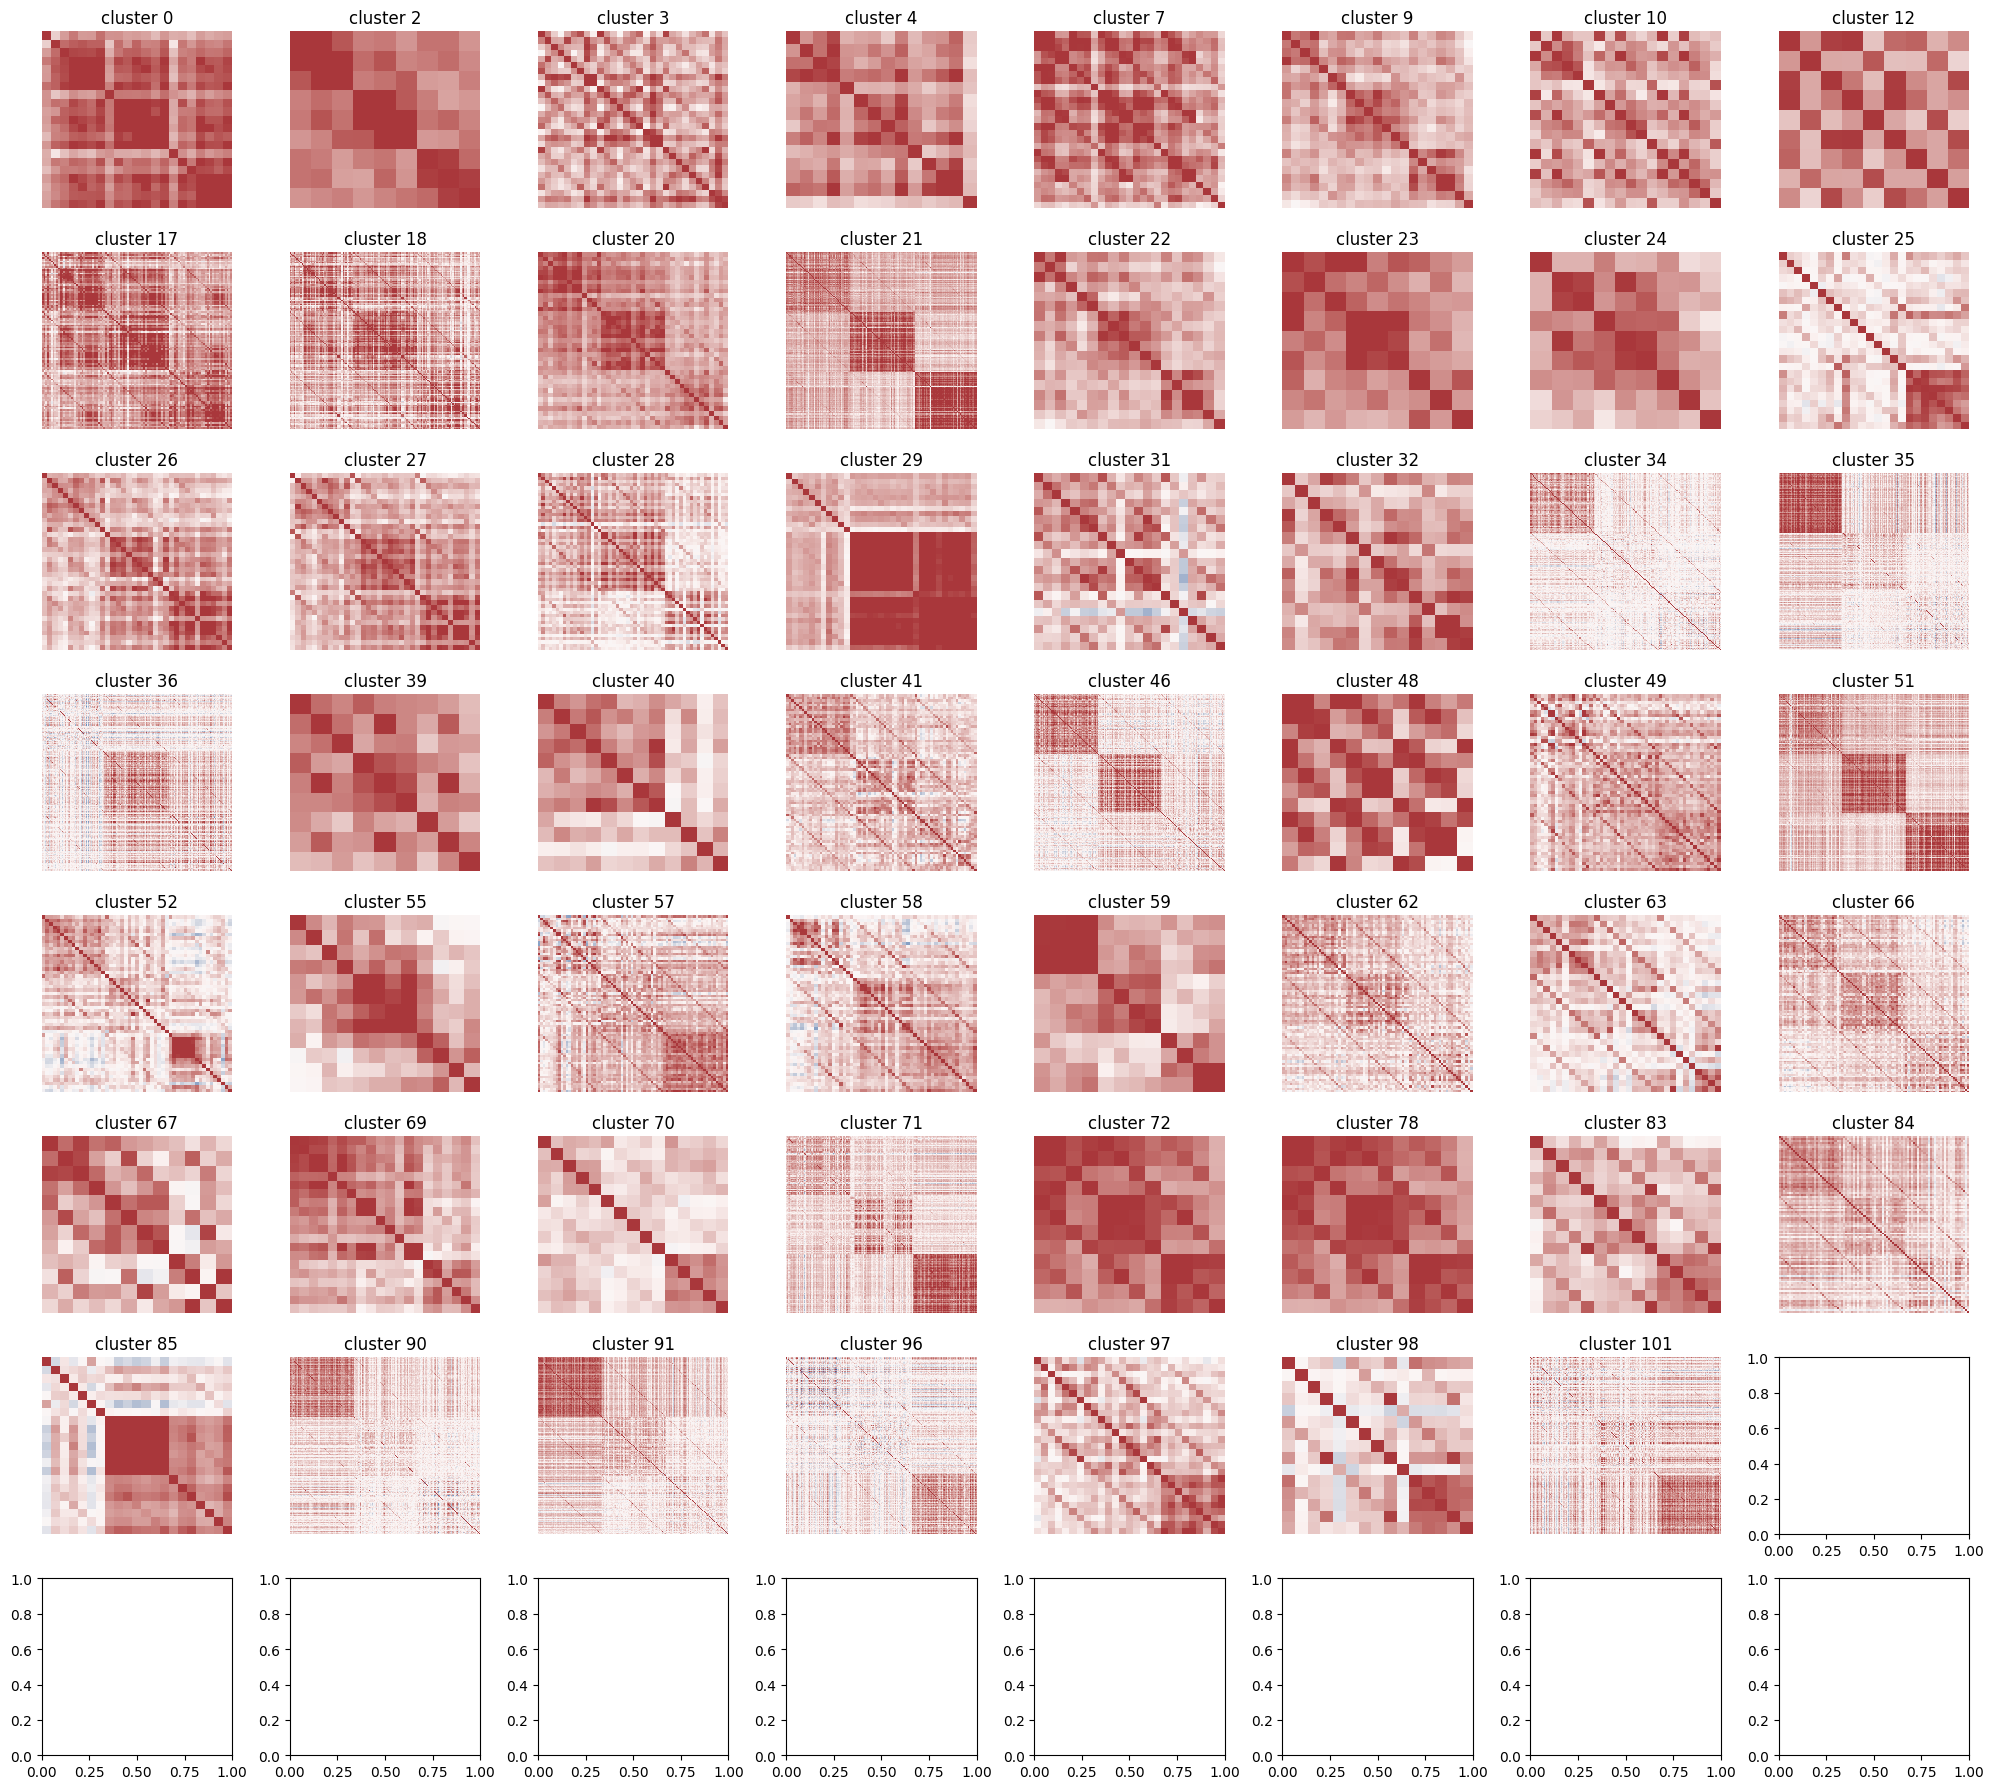

In [12]:
fig, axes = plt.subplots(8,8,figsize=(20,18))
ax = axes.flatten()
cluster_list = np.sort(adata_final.obs.hdbscan.unique())
for i in range(55):
    genelist = adata_final[adata_final.obs.hdbscan==cluster_list[i]].obs.target_contrast_gene_name_corrected.unique().tolist()
    corr_mtx = corr_compute(adata_de, genelist)
    sns.heatmap(corr_mtx, vmin=-0.5, vmax=0.5, cmap='vlag', ax=ax[i], xticklabels=[], yticklabels=[], cbar=False)
    ax[i].set_title('cluster '+str(cluster_list[i]))
plt.tight_layout()

In [134]:
stim48hr_specific_cluster = [25, 57, 70, 97, 98, 101]
rest_specific_cluster = [34, 35, 90, 91]
stim8hr_specific_cluster = [36, 55, 85]
rest_stim8hr_cluster = [20, 40, 41, 46, 62, 66]
stim8hr_stim48hr_cluster = [29]

### First check gene expression

In [242]:
df_mean_std = pd.DataFrame({'condition': ['Rest', 'Rest', 'Stim8hr', 'Stim8hr', 'Stim48hr', 'Stim48hr'],
                            'mean_or_std': ['mean', 'std', 'mean', 'std', 'mean', 'std'],
                            'values': [de_summary_stats[de_summary_stats.condition=='Rest'].baseMean.mean(),
                                       de_summary_stats[de_summary_stats.condition=='Rest'].baseMean.std(),
                                       de_summary_stats[de_summary_stats.condition=='Stim8hr'].baseMean.mean(),
                                       de_summary_stats[de_summary_stats.condition=='Stim8hr'].baseMean.std(),
                                       de_summary_stats[de_summary_stats.condition=='Stim48hr'].baseMean.mean(),
                                       de_summary_stats[de_summary_stats.condition=='Stim48hr'].baseMean.std()]})

def calculate_expression_zscore(row, df_mean_std):
    """
    Calculate zscore of gene expression from mean expression of matching condition
    """
    mean = df_mean_std[(df_mean_std['condition']==row['condition'])&(df_mean_std['mean_or_std']=='mean')]['values'].values[0]
    std = df_mean_std[(df_mean_std['condition']==row['condition'])&(df_mean_std['mean_or_std']=='std')]['values'].values[0]
    
    return (row['baseMean'] - mean)/std

In [243]:
de_summary_stats['baseMean_zscore'] = de_summary_stats.apply(calculate_expression_zscore, axis=1, df_mean_std=df_mean_std)

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_2020/499373335.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df])


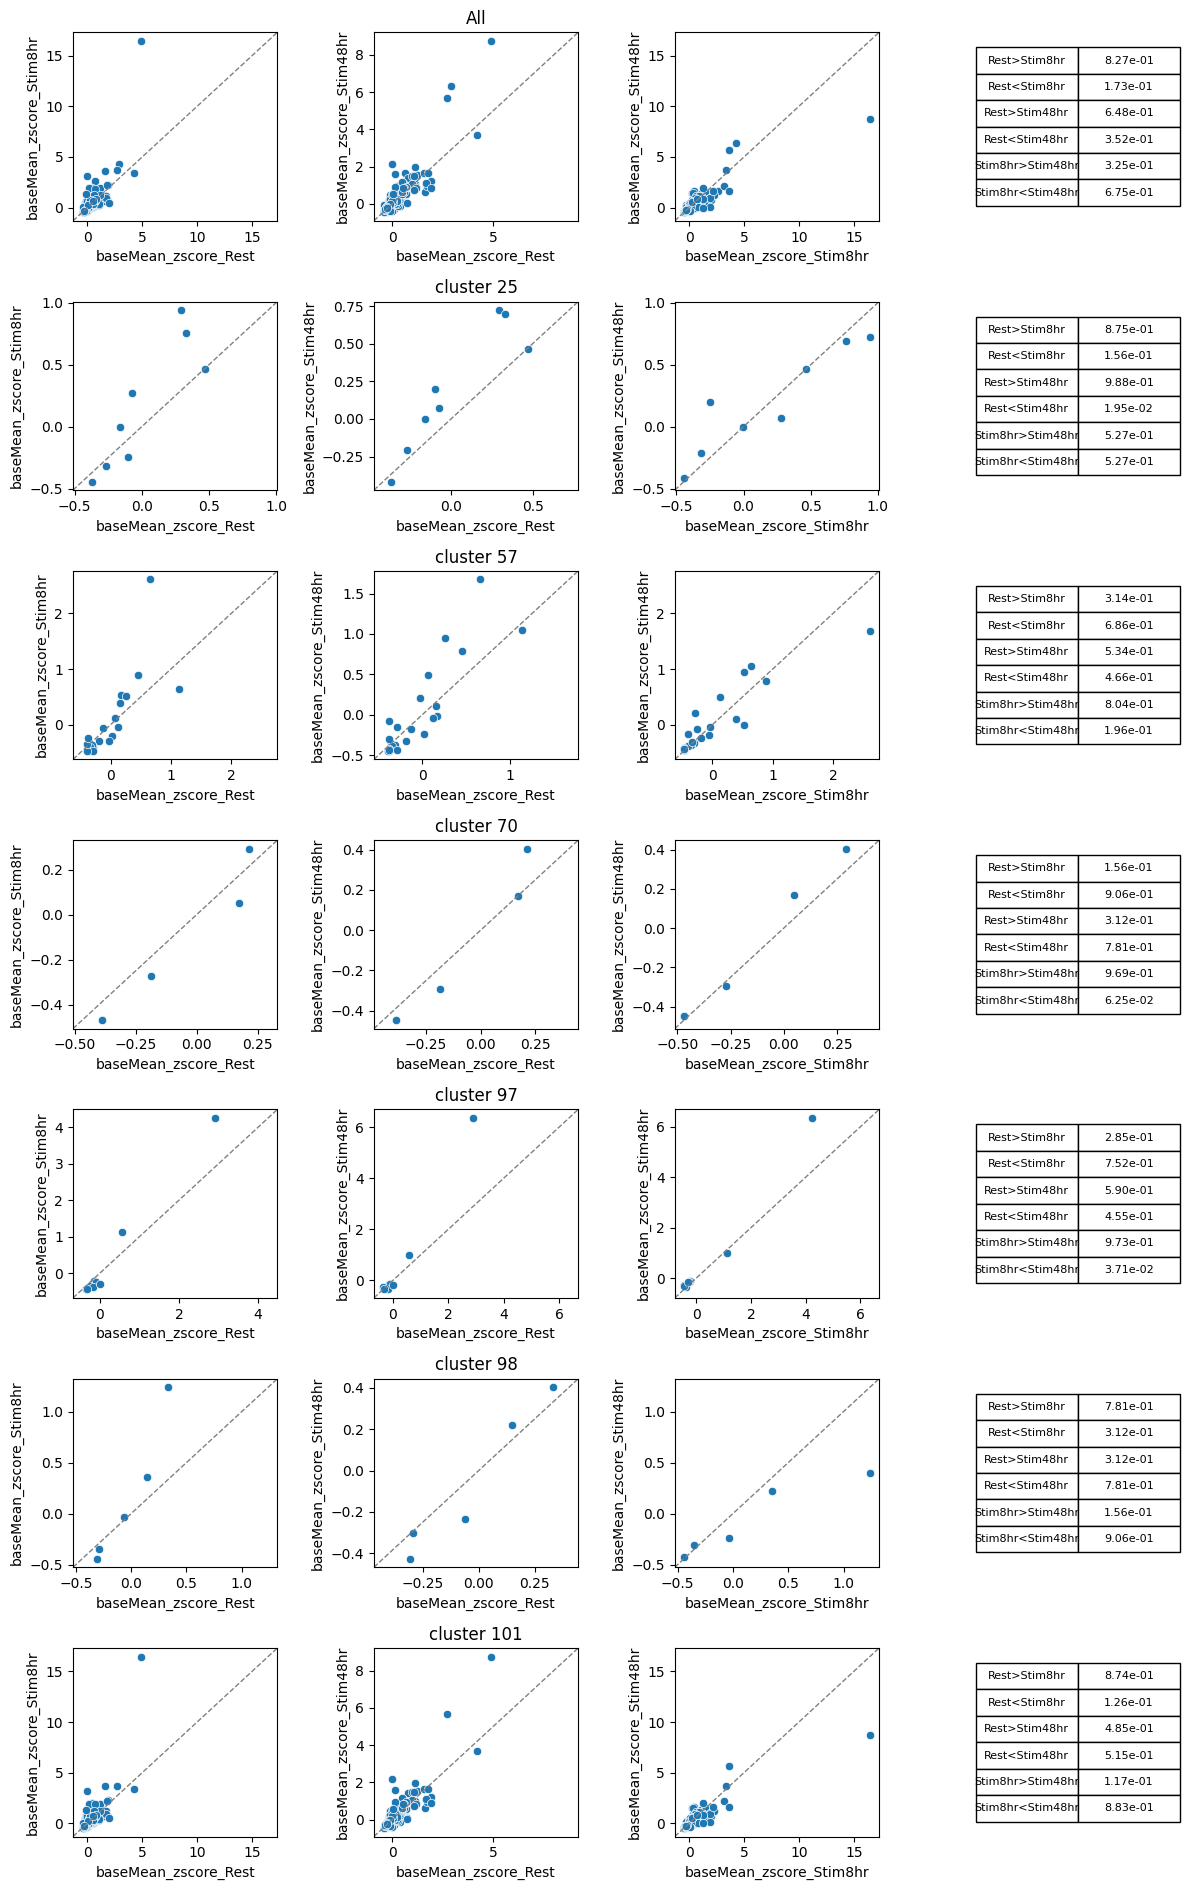

In [273]:
df_all = pd.DataFrame(columns=['baseMean_zscore_Rest','baseMean_zscore_Stim8hr','baseMean_zscore_Stim48hr'])
fig, ax = plt.subplots(len(stim48hr_specific_cluster)+1,4,figsize=(12,3*len(stim48hr_specific_cluster)+1))
for i, cluster in enumerate(stim48hr_specific_cluster):
    genelist = adata_final[adata_final.obs.hdbscan==cluster].obs.target_contrast_gene_name_corrected.unique().tolist()

    # Get zscore dataframe
    df = de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Rest')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected')
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim8hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True, suffixes=('_Rest', '_Stim8hr'))
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim48hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True)
    df = df.rename(columns={'baseMean_zscore': 'baseMean_zscore_Stim48hr'})
    
    comparison = []
    pvalues = []
    condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
    for j, pair in enumerate(condition_pair):
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
        comparison.append(pair[0]+'>'+pair[1])
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
        comparison.append(pair[0]+'<'+pair[1])
        sns.scatterplot(df, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[i+1,j])
        min_val = min(df['baseMean_zscore_'+pair[0]].min(), df['baseMean_zscore_'+pair[1]].min())
        max_val = max(df['baseMean_zscore_'+pair[0]].max(), df['baseMean_zscore_'+pair[1]].max())
        buffer = (max_val - min_val) * 0.05
        min_limit = min_val - buffer
        max_limit = max_val + buffer
        ax[i+1,j].set_xlim(min_limit, max_limit)
        ax[i+1,j].set_ylim(min_limit, max_limit)
        ax[i+1,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)
    
    df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
    df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
    table = ax[i+1,3].table(df_comparison.values, cellLoc='center', loc='center')
    ax[i+1,3].axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    df_all = pd.concat([df_all, df])
    ax[i+1,1].set_title('cluster '+str(cluster))

# calculate significance of all 
comparison = []
pvalues = []
condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
for j, pair in enumerate(condition_pair):
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
    comparison.append(pair[0]+'>'+pair[1])
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
    comparison.append(pair[0]+'<'+pair[1])
    sns.scatterplot(df_all, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[0,j])
    min_val = min(df_all['baseMean_zscore_'+pair[0]].min(), df_all['baseMean_zscore_'+pair[1]].min())
    max_val = max(df_all['baseMean_zscore_'+pair[0]].max(), df_all['baseMean_zscore_'+pair[1]].max())
    buffer = (max_val - min_val) * 0.05
    min_limit = min_val - buffer
    max_limit = max_val + buffer
    ax[0,j].set_xlim(min_limit, max_limit)
    ax[0,j].set_ylim(min_limit, max_limit)
    ax[0,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)

df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
table = ax[0,3].table(df_comparison.values, cellLoc='center', loc='center')
ax[0,3].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
ax[0,1].set_title('All')

plt.tight_layout()

plt.savefig('results/stim48hr_specific_cluster_baseMean_zscore_comparison.png')

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_2020/3760824205.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df])


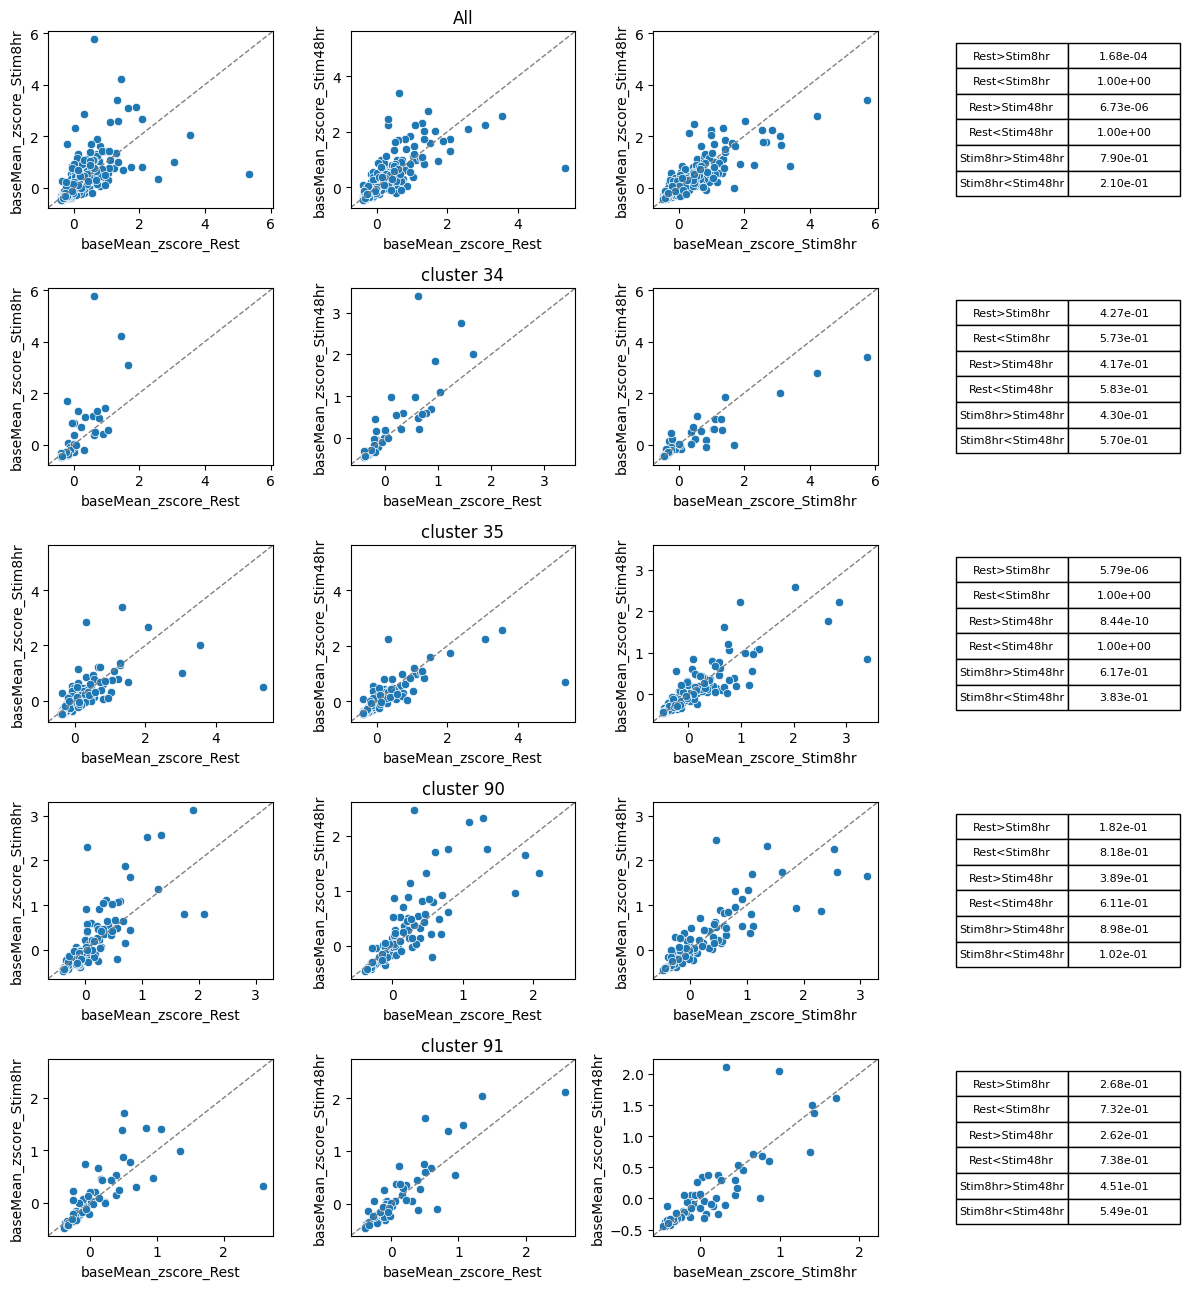

In [274]:
df_all = pd.DataFrame(columns=['baseMean_zscore_Rest','baseMean_zscore_Stim8hr','baseMean_zscore_Stim48hr'])
fig, ax = plt.subplots(len(rest_specific_cluster)+1,4,figsize=(12,3*len(rest_specific_cluster)+1))
for i, cluster in enumerate(rest_specific_cluster):
    genelist = adata_final[adata_final.obs.hdbscan==cluster].obs.target_contrast_gene_name_corrected.unique().tolist()

    # Get zscore dataframe
    df = de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Rest')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected')
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim8hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True, suffixes=('_Rest', '_Stim8hr'))
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim48hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True)
    df = df.rename(columns={'baseMean_zscore': 'baseMean_zscore_Stim48hr'})
    
    comparison = []
    pvalues = []
    condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
    for j, pair in enumerate(condition_pair):
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
        comparison.append(pair[0]+'>'+pair[1])
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
        comparison.append(pair[0]+'<'+pair[1])
        sns.scatterplot(df, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[i+1,j])
        min_val = min(df['baseMean_zscore_'+pair[0]].min(), df['baseMean_zscore_'+pair[1]].min())
        max_val = max(df['baseMean_zscore_'+pair[0]].max(), df['baseMean_zscore_'+pair[1]].max())
        buffer = (max_val - min_val) * 0.05
        min_limit = min_val - buffer
        max_limit = max_val + buffer
        ax[i+1,j].set_xlim(min_limit, max_limit)
        ax[i+1,j].set_ylim(min_limit, max_limit)
        ax[i+1,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)
    
    df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
    df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
    table = ax[i+1,3].table(df_comparison.values, cellLoc='center', loc='center')
    ax[i+1,3].axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    df_all = pd.concat([df_all, df])
    ax[i+1,1].set_title('cluster '+str(cluster))

# calculate significance of all 
comparison = []
pvalues = []
condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
for j, pair in enumerate(condition_pair):
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
    comparison.append(pair[0]+'>'+pair[1])
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
    comparison.append(pair[0]+'<'+pair[1])
    sns.scatterplot(df_all, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[0,j])
    min_val = min(df_all['baseMean_zscore_'+pair[0]].min(), df_all['baseMean_zscore_'+pair[1]].min())
    max_val = max(df_all['baseMean_zscore_'+pair[0]].max(), df_all['baseMean_zscore_'+pair[1]].max())
    buffer = (max_val - min_val) * 0.05
    min_limit = min_val - buffer
    max_limit = max_val + buffer
    ax[0,j].set_xlim(min_limit, max_limit)
    ax[0,j].set_ylim(min_limit, max_limit)
    ax[0,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)

df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
table = ax[0,3].table(df_comparison.values, cellLoc='center', loc='center')
ax[0,3].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
ax[0,1].set_title('All')

plt.tight_layout()

plt.savefig('results/rest_specific_cluster_baseMean_zscore_comparison.png')

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_2020/3975744631.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df])


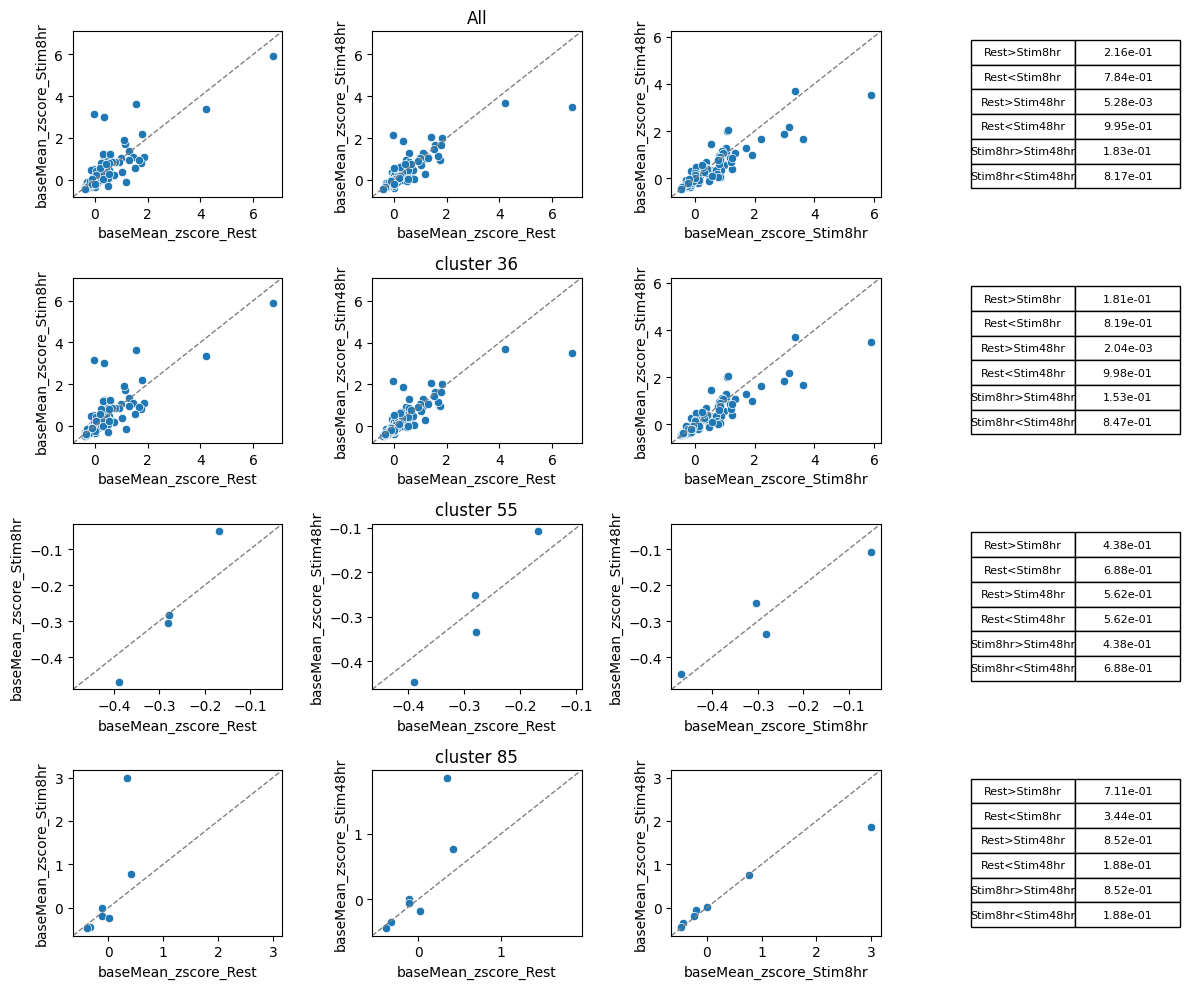

In [275]:
df_all = pd.DataFrame(columns=['baseMean_zscore_Rest','baseMean_zscore_Stim8hr','baseMean_zscore_Stim48hr'])
fig, ax = plt.subplots(len(stim8hr_specific_cluster)+1,4,figsize=(12,3*len(stim8hr_specific_cluster)+1))
for i, cluster in enumerate(stim8hr_specific_cluster):
    genelist = adata_final[adata_final.obs.hdbscan==cluster].obs.target_contrast_gene_name_corrected.unique().tolist()

    # Get zscore dataframe
    df = de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Rest')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected')
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim8hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True, suffixes=('_Rest', '_Stim8hr'))
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim48hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True)
    df = df.rename(columns={'baseMean_zscore': 'baseMean_zscore_Stim48hr'})
    
    comparison = []
    pvalues = []
    condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
    for j, pair in enumerate(condition_pair):
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
        comparison.append(pair[0]+'>'+pair[1])
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
        comparison.append(pair[0]+'<'+pair[1])
        sns.scatterplot(df, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[i+1,j])
        min_val = min(df['baseMean_zscore_'+pair[0]].min(), df['baseMean_zscore_'+pair[1]].min())
        max_val = max(df['baseMean_zscore_'+pair[0]].max(), df['baseMean_zscore_'+pair[1]].max())
        buffer = (max_val - min_val) * 0.05
        min_limit = min_val - buffer
        max_limit = max_val + buffer
        ax[i+1,j].set_xlim(min_limit, max_limit)
        ax[i+1,j].set_ylim(min_limit, max_limit)
        ax[i+1,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)
    
    df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
    df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
    table = ax[i+1,3].table(df_comparison.values, cellLoc='center', loc='center')
    ax[i+1,3].axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    df_all = pd.concat([df_all, df])
    ax[i+1,1].set_title('cluster '+str(cluster))

# calculate significance of all 
comparison = []
pvalues = []
condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
for j, pair in enumerate(condition_pair):
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
    comparison.append(pair[0]+'>'+pair[1])
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
    comparison.append(pair[0]+'<'+pair[1])
    sns.scatterplot(df_all, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[0,j])
    min_val = min(df_all['baseMean_zscore_'+pair[0]].min(), df_all['baseMean_zscore_'+pair[1]].min())
    max_val = max(df_all['baseMean_zscore_'+pair[0]].max(), df_all['baseMean_zscore_'+pair[1]].max())
    buffer = (max_val - min_val) * 0.05
    min_limit = min_val - buffer
    max_limit = max_val + buffer
    ax[0,j].set_xlim(min_limit, max_limit)
    ax[0,j].set_ylim(min_limit, max_limit)
    ax[0,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)

df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
table = ax[0,3].table(df_comparison.values, cellLoc='center', loc='center')
ax[0,3].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
ax[0,1].set_title('All')

plt.tight_layout()

plt.savefig('results/stim8hr_specific_cluster_baseMean_zscore_comparison.png')

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_2020/4257736183.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df])


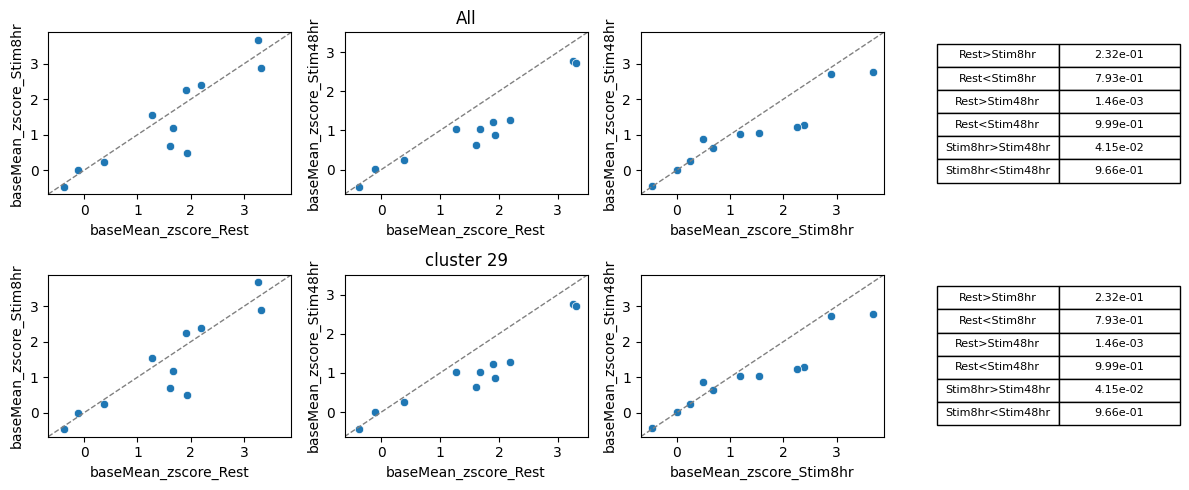

In [277]:
df_all = pd.DataFrame(columns=['baseMean_zscore_Rest','baseMean_zscore_Stim8hr','baseMean_zscore_Stim48hr'])
fig, ax = plt.subplots(len(stim8hr_stim48hr_cluster)+1,4,figsize=(12,4*len(stim8hr_stim48hr_cluster)+1))
for i, cluster in enumerate(stim8hr_stim48hr_cluster):
    genelist = adata_final[adata_final.obs.hdbscan==cluster].obs.target_contrast_gene_name_corrected.unique().tolist()

    # Get zscore dataframe
    df = de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Rest')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected')
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim8hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True, suffixes=('_Rest', '_Stim8hr'))
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim48hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True)
    df = df.rename(columns={'baseMean_zscore': 'baseMean_zscore_Stim48hr'})
    
    comparison = []
    pvalues = []
    condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
    for j, pair in enumerate(condition_pair):
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
        comparison.append(pair[0]+'>'+pair[1])
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
        comparison.append(pair[0]+'<'+pair[1])
        sns.scatterplot(df, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[i+1,j])
        min_val = min(df['baseMean_zscore_'+pair[0]].min(), df['baseMean_zscore_'+pair[1]].min())
        max_val = max(df['baseMean_zscore_'+pair[0]].max(), df['baseMean_zscore_'+pair[1]].max())
        buffer = (max_val - min_val) * 0.05
        min_limit = min_val - buffer
        max_limit = max_val + buffer
        ax[i+1,j].set_xlim(min_limit, max_limit)
        ax[i+1,j].set_ylim(min_limit, max_limit)
        ax[i+1,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)
    
    df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
    df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
    table = ax[i+1,3].table(df_comparison.values, cellLoc='center', loc='center')
    ax[i+1,3].axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    df_all = pd.concat([df_all, df])
    ax[i+1,1].set_title('cluster '+str(cluster))

# calculate significance of all 
comparison = []
pvalues = []
condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
for j, pair in enumerate(condition_pair):
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
    comparison.append(pair[0]+'>'+pair[1])
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
    comparison.append(pair[0]+'<'+pair[1])
    sns.scatterplot(df_all, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[0,j])
    min_val = min(df_all['baseMean_zscore_'+pair[0]].min(), df_all['baseMean_zscore_'+pair[1]].min())
    max_val = max(df_all['baseMean_zscore_'+pair[0]].max(), df_all['baseMean_zscore_'+pair[1]].max())
    buffer = (max_val - min_val) * 0.05
    min_limit = min_val - buffer
    max_limit = max_val + buffer
    ax[0,j].set_xlim(min_limit, max_limit)
    ax[0,j].set_ylim(min_limit, max_limit)
    ax[0,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)

df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
table = ax[0,3].table(df_comparison.values, cellLoc='center', loc='center')
ax[0,3].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
ax[0,1].set_title('All')

plt.tight_layout()

plt.savefig('results/stim8hr_stim48hr_cluster_baseMean_zscore_comparison.png')

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_2020/1438141475.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df])


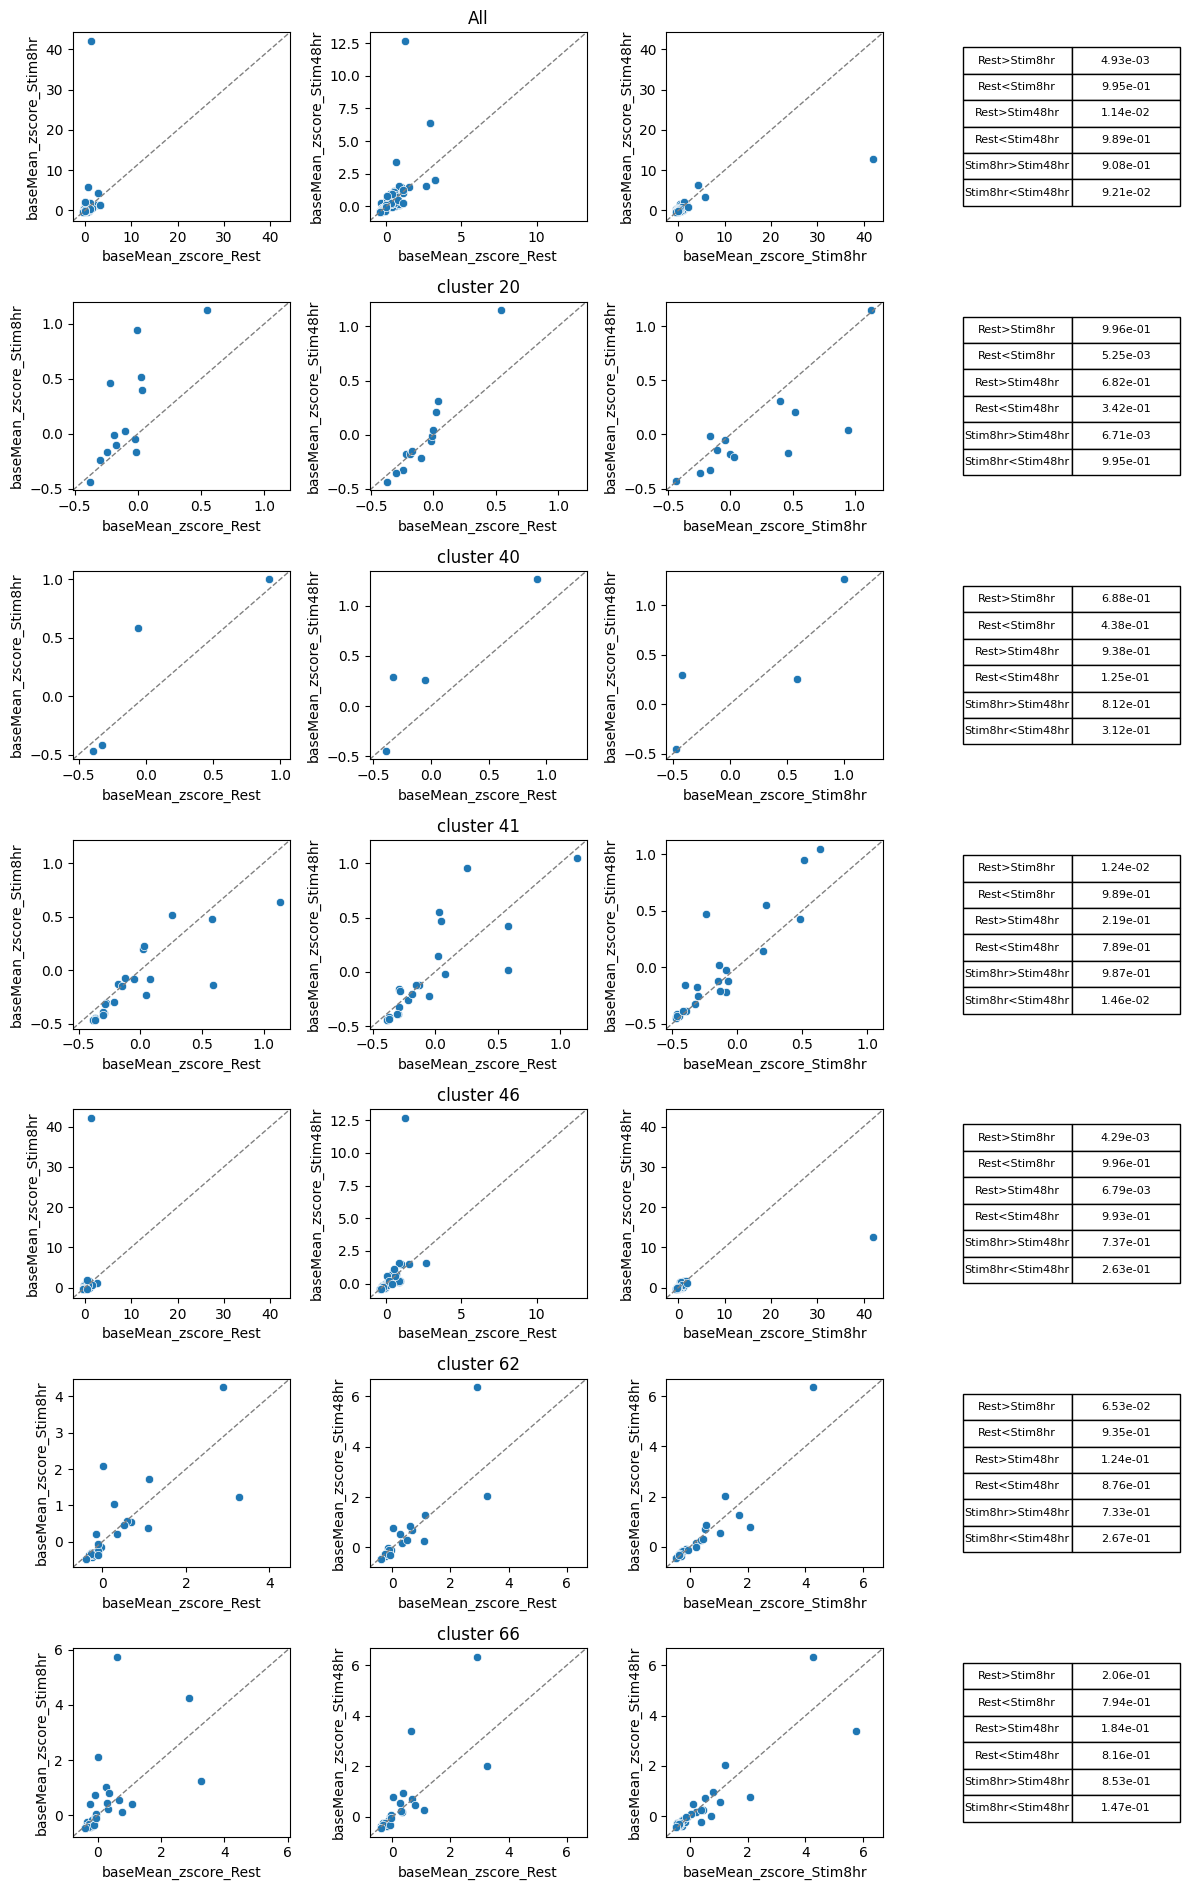

In [279]:
df_all = pd.DataFrame(columns=['baseMean_zscore_Rest','baseMean_zscore_Stim8hr','baseMean_zscore_Stim48hr'])
fig, ax = plt.subplots(len(rest_stim8hr_cluster)+1,4,figsize=(12,3*len(rest_stim8hr_cluster)+1))
for i, cluster in enumerate(rest_stim8hr_cluster):
    genelist = adata_final[adata_final.obs.hdbscan==cluster].obs.target_contrast_gene_name_corrected.unique().tolist()

    # Get zscore dataframe
    df = de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Rest')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected')
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim8hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True, suffixes=('_Rest', '_Stim8hr'))
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim48hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True)
    df = df.rename(columns={'baseMean_zscore': 'baseMean_zscore_Stim48hr'})
    
    comparison = []
    pvalues = []
    condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
    for j, pair in enumerate(condition_pair):
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
        comparison.append(pair[0]+'>'+pair[1])
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
        comparison.append(pair[0]+'<'+pair[1])
        sns.scatterplot(df, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[i+1,j])
        min_val = min(df['baseMean_zscore_'+pair[0]].min(), df['baseMean_zscore_'+pair[1]].min())
        max_val = max(df['baseMean_zscore_'+pair[0]].max(), df['baseMean_zscore_'+pair[1]].max())
        buffer = (max_val - min_val) * 0.05
        min_limit = min_val - buffer
        max_limit = max_val + buffer
        ax[i+1,j].set_xlim(min_limit, max_limit)
        ax[i+1,j].set_ylim(min_limit, max_limit)
        ax[i+1,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)
    
    df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
    df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
    table = ax[i+1,3].table(df_comparison.values, cellLoc='center', loc='center')
    ax[i+1,3].axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    df_all = pd.concat([df_all, df])
    ax[i+1,1].set_title('cluster '+str(cluster))

# calculate significance of all 
comparison = []
pvalues = []
condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
for j, pair in enumerate(condition_pair):
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
    comparison.append(pair[0]+'>'+pair[1])
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
    comparison.append(pair[0]+'<'+pair[1])
    sns.scatterplot(df_all, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[0,j])
    min_val = min(df_all['baseMean_zscore_'+pair[0]].min(), df_all['baseMean_zscore_'+pair[1]].min())
    max_val = max(df_all['baseMean_zscore_'+pair[0]].max(), df_all['baseMean_zscore_'+pair[1]].max())
    buffer = (max_val - min_val) * 0.05
    min_limit = min_val - buffer
    max_limit = max_val + buffer
    ax[0,j].set_xlim(min_limit, max_limit)
    ax[0,j].set_ylim(min_limit, max_limit)
    ax[0,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)

df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
table = ax[0,3].table(df_comparison.values, cellLoc='center', loc='center')
ax[0,3].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
ax[0,1].set_title('All')

plt.tight_layout()

plt.savefig('results/rest_stim8hr_cluster_baseMean_zscore_comparison.png')

### Then check downstream gene expression

In [285]:
stim48hr_specific_cluster

[25, 57, 70, 97, 98, 101]

In [296]:
cluster = 101
condition = 'Stim48hr'
genelist = adata_final[adata_final.obs.hdbscan==cluster].obs.target_contrast_gene_name_corrected.unique().tolist()

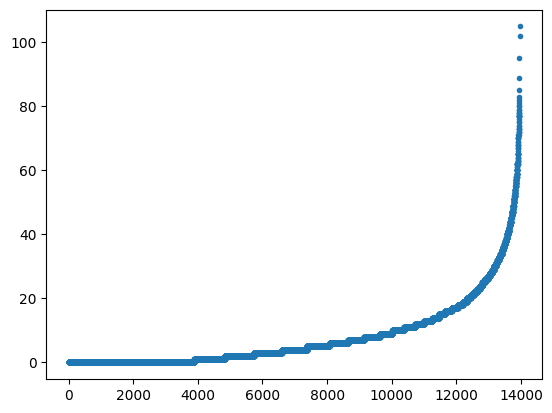

In [297]:
plt.plot(np.sort(np.sum(adata_de[(adata_de.obs.target_contrast_gene_name_corrected.isin(genelist))&(adata_de.obs.culture_condition==condition)].layers['adj_p_value']<0.1, axis=0)), '.')

In [281]:
adata_de.var[np.sum(adata_de[(adata_de.obs.target_contrast_gene_name_corrected.isin(genelist))&(adata_de.obs.culture_condition==condition)].layers['adj_p_value']<0.1, axis=0)!=0].gene_name

ENSG00000000419               DPM1
ENSG00000000457              SCYL3
ENSG00000000460           C1orf112
ENSG00000001461             NIPAL3
ENSG00000001629             ANKIB1
                        ...       
ENSG00000284024            MSANTD7
ENSG00000284194               SCO2
ENSG00000284770               TBCE
ENSG00000288701             PRRC2B
ENSG00000290797    ENSG00000290797
Name: gene_name, Length: 6421, dtype: object

In [227]:
adata_de.var[np.sum(adata_de[(adata_de.obs.target_contrast_gene_name_corrected.isin(genelist))&(adata_de.obs.culture_condition==condition)].layers['adj_p_value']<0.1, axis=0)!=0].gene_name

,gene_ids,gene_name
ENSG00000000419,ENSG00000000419,DPM1
ENSG00000000457,ENSG00000000457,SCYL3
ENSG00000000460,ENSG00000000460,C1orf112
ENSG00000000971,ENSG00000000971,CFH
ENSG00000001036,ENSG00000001036,FUCA2
...,...,...
ENSG00000288701,ENSG00000288701,PRRC2B
ENSG00000288722,ENSG00000288722,F8A1
ENSG00000290292,ENSG00000290292,HOMEZ
ENSG00000290797,ENSG00000290797,ENSG00000290797


In [214]:
cluster = 101
condition = 'Stim48hr'
genelist = adata_final[adata_final.obs.hdbscan==cluster].obs.target_contrast_gene_name_corrected.unique().tolist()
downstream_genelist = []
for gene in genelist:
    adata_final[adata_final.obs.target_contrast_gene_name_corrected..unique().tolist()

In [ ]:
genelist

In [ ]:
df = de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Rest')][['baseMean', 'condition', 'target_name_corrected']]
df = pd.concat([df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim8hr')][['baseMean', 'condition', 'target_name_corrected']]])
df = pd.concat([df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim48hr')][['baseMean', 'condition', 'target_name_corrected']]])
df['zscore'] = df.apply(calculate_expression_zscore, axis=1, df_mean_std=df_mean_std)

In [ ]:


comparison = []
pvalues = []
condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
for pair in condition_pair:
    pvalues.append(stats.mannwhitneyu(df[df['condition']==pair[0]]['zscore'], df[df['condition']==pair[1]]['zscore'], alternative='greater').pvalue)
    comparison.append(pair[0]+'>'+pair[1])
    pvalues.append(stats.mannwhitneyu(df[df['condition']==pair[0]]['zscore'], df[df['condition']==pair[1]]['zscore'], alternative='less').pvalue)
    comparison.append(pair[0]+'<'+pair[1])

df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")